# Problem
California is a big state of America. The population of California is about 39.56 million (2018). California is divided into 58 counties. In this capstone project, we suppose that one restaurant investor who want to know where he/she should invest for new restaurant.. One feasible solution is clustering of counties base on some their characteristics such as population, median of income, House price, Number of existing restaurant in the county. The information of clusters could help the investor to make decision. Therefore, we will collect data of county characteristics. Then, we will cluster the counties of California based on set given feature set. 

# Data
At the beginning, we collect data about population, Income, house price and using Foursquare to get information about venues of each county. The data sources as below

1. Population & Income : https://en.wikipedia.org/wiki/List_of_California_locations_by_income
2. House Price : https://www.zillow.com/research/data/ 
3. Foursquare API

# Method
1. Preparing data
- Population and income data are scrapped from wikipedia
- House Price is downloaded from Zillow website in csv file
- Merging data from the two sources above
- Get venues data using Foursquare API
- Filter revues "restaurant" category 
2. Clustering
- Clustering county suing Kmean into 4 clusters
- Features : Population, Per_captita_Income, Family Income, House Price, Num of Restaurant
3. Visualize data on map using Folium

# Analyze the result
1. Per_Captipol_Income is correlated with the House Price
2. Cluster 3 includes the counties which has many restaurants
3. Los Angeles is one cluster seperated with other county
4. The others clusters need anlyze more. Almost counties in this cluster has zero restaurant


# Conclusion
In this capstone project, we have collect date from many sources, pre-process data to get the given fearues of each county. Then, The K-Mean Clustering is used to cluster the counties of california into 4 clusters. At the end, we visualize the clusets on the map using Folium library.
Given features for clustering need to be evaluated

# I. Data preparation

## Data Loading from Wiki

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sn
import numpy as np
from geopy.geocoders import Nominatim
import folium
import json
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
# Get Population and income data from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_California_locations_by_income'
dfs = pd.read_html(url)
df_income = dfs[1]

In [3]:
df_income.head()

,County,Population[1],Populationdensity[1][2][note 1],Per capita income[3],Median household income[6],Median family income[5]
0,Alameda,1559308,2109.8,"$36,439","$73,775","$90,822"
1,Alpine,1202,1.6,"$24,375","$61,343","$71,932"
2,Amador,37159,62.5,"$27,373","$52,964","$68,765"
3,Butte,221578,135.4,"$24,430","$43,165","$56,934"
4,Calaveras,44921,44.0,"$29,296","$54,936","$67,100"


## Columns renaming and data type converting

In [4]:
df_income.columns =['County','Population','Density','Per_capita_income','Household income','Family income']

In [5]:
df_income.head()

,County,Population,Density,Per_capita_income,Household income,Family income
0,Alameda,1559308,2109.8,"$36,439","$73,775","$90,822"
1,Alpine,1202,1.6,"$24,375","$61,343","$71,932"
2,Amador,37159,62.5,"$27,373","$52,964","$68,765"
3,Butte,221578,135.4,"$24,430","$43,165","$56,934"
4,Calaveras,44921,44.0,"$29,296","$54,936","$67,100"


In [6]:
# Data Type Converting
df_income['Population'] = df_income['Population'].astype(int)
df_income[['Per_capita_income']] = df_income[['Per_capita_income']].replace('[\$,]','',regex=True).astype(float)
df_income[['Household income']] = df_income[['Household income']].replace('[\$,]','',regex=True).astype(float)
df_income[['Family income']] = df_income[['Family income']].replace('[\$,]','',regex=True).astype(float)

In [7]:
df_income.head()

,County,Population,Density,Per_capita_income,Household income,Family income
0,Alameda,1559308,2109.8,36439.0,73775.0,90822.0
1,Alpine,1202,1.6,24375.0,61343.0,71932.0
2,Amador,37159,62.5,27373.0,52964.0,68765.0
3,Butte,221578,135.4,24430.0,43165.0,56934.0
4,Calaveras,44921,44.0,29296.0,54936.0,67100.0


In [8]:
# Write to disk
df_income.to_csv('Population_Income.csv')

## Loading House price from Zillow's csv file

In [9]:
# Load price house data from cvs file
df_house_price = pd.read_csv("County_Zhvi_AllHomes.csv")

In [10]:
df_house_price.head()

,RegionID,RegionName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,SizeRank,1996-04,1996-05,1996-06,...,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02
0,3101,Los Angeles County,CA,Los Angeles-Long Beach-Anaheim,6,37,1,176818.0,176955.0,177134.0,...,625786,627162,627902,629576,632000,635385,638392,643078,648206,656790
1,139,Cook County,IL,Chicago-Naperville-Elgin,17,31,2,148775.0,148353.0,148412.0,...,246290,246354,246654,246680,246455,246124,245771,245439,245238,245151
2,1090,Harris County,TX,Houston-The Woodlands-Sugar Land,48,201,3,101060.0,101208.0,101305.0,...,197520,197991,198633,199173,199499,200020,200439,200878,200888,201171
3,2402,Maricopa County,AZ,Phoenix-Mesa-Scottsdale,4,13,4,118611.0,119312.0,119944.0,...,282783,283993,285447,287281,288866,290643,292529,294716,296854,298760
4,2841,San Diego County,CA,San Diego-Carlsbad,6,73,5,180776.0,180589.0,180435.0,...,593523,595218,596989,598589,600515,602130,605256,609134,614512,619887


In [11]:
df_house_price = df_house_price[df_house_price['State']=="CA"]

In [12]:
df_house_price.shape

(58, 294)

In [13]:
df_house_price.columns

Index(['RegionID', 'RegionName', 'State', 'Metro', 'StateCodeFIPS',
       'MunicipalCodeFIPS', 'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10',
       '2019-11', '2019-12', '2020-01', '2020-02'],
      dtype='object', length=294)

In [14]:
df_house_price = df_house_price[['RegionName','2020-02']]

In [15]:
df_house_price.columns =['County','HousePrice']

In [16]:
df_house_price['County']=df_house_price['County'].replace(' County',"",regex=True)

In [17]:
df_house_price.shape

(58, 2)

## Merging two dataframes

In [18]:
df = pd.merge(df_income,df_house_price,on='County')

In [19]:
df.head()

,County,Population,Density,Per_capita_income,Household income,Family income,HousePrice
0,Alameda,1559308,2109.8,36439.0,73775.0,90822.0,880231
1,Alpine,1202,1.6,24375.0,61343.0,71932.0,424684
2,Amador,37159,62.5,27373.0,52964.0,68765.0,312764
3,Butte,221578,135.4,24430.0,43165.0,56934.0,327236
4,Calaveras,44921,44.0,29296.0,54936.0,67100.0,330958


In [20]:
df.shape

(58, 7)

## Features Analyzing

In [21]:
df.describe()

,Population,Density,Per_capita_income,Household income,Family income,HousePrice
count,5.800000e+01,58.000000,58.000000,58.000000,58.000000,5.800000e+01
mean,6.563262e+05,680.206897,27604.344828,56034.362069,66744.344828,4.699471e+05
std,1.443529e+06,2381.703846,8198.398555,14428.471908,17164.865156,2.918424e+05
min,1.202000e+03,1.600000,16409.000000,35997.000000,45296.000000,1.307210e+05
25%,4.727750e+04,25.725000,21754.250000,44717.250000,52788.750000,2.798242e+05
50%,1.799925e+05,105.900000,26190.000000,53302.000000,62945.000000,3.669245e+05
75%,6.564860e+05,341.000000,30913.750000,63946.750000,75677.250000,6.177612e+05
max,9.974203e+06,17680.100000,58004.000000,93854.000000,120030.000000,1.436140e+06


In [26]:
corr = df.corr()
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel("corr_matrix1.xlsx", engine="openpyxl")

,Population,Density,Per_capita_income,Household income,Family income,HousePrice
Population,1.000000,0.214050,0.129885,0.213370,0.136799,0.259032
Density,0.214050,1.000000,0.473253,0.355580,0.338975,0.576835
Per_capita_income,0.129885,0.473253,1.000000,0.871630,0.935717,0.891513
Household income,0.213370,0.355580,0.871630,1.000000,0.962003,0.882805
Family income,0.136799,0.338975,0.935717,0.962003,1.000000,0.874614
HousePrice,0.259032,0.576835,0.891513,0.882805,0.874614,1.000000


In [ ]:
corr.style.background_gradient(cmap='coolwarm')

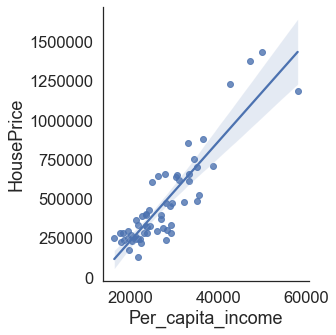

<Figure size 432x288 with 0 Axes>

In [27]:
# Visualize highest correclation 
sn.set(font_scale=1.5,style="white")
sn.lmplot(x="Per_capita_income",y="HousePrice",data=df)
plt.show()
plt.savefig('The_best_correlation.png')

# II. Visualzing counties of CA

In [28]:
df.head()

,County,Population,Density,Per_capita_income,Household income,Family income,HousePrice
0,Alameda,1559308,2109.8,36439.0,73775.0,90822.0,880231
1,Alpine,1202,1.6,24375.0,61343.0,71932.0,424684
2,Amador,37159,62.5,27373.0,52964.0,68765.0,312764
3,Butte,221578,135.4,24430.0,43165.0,56934.0,327236
4,Calaveras,44921,44.0,29296.0,54936.0,67100.0,330958


In [29]:
Counties = pd.Series(df['County'])
len(Counties)

58

In [30]:
# define the dataframe columns
column_names = ['County', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_geo = pd.DataFrame(columns=column_names)

In [31]:
geolocator = Nominatim(user_agent="ca_explorer",timeout=10)

for data in Counties:
    data2 = data + ' California'
    location = geolocator.geocode(data2)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
        df_geo = df_geo.append({ 'County': data,
                            'Latitude': latitude,
                            'Longitude': longitude}, ignore_index=True)


In [32]:
df_geo.head()

,County,Latitude,Longitude
0,Alameda,-22.702461,-45.545968
1,Alpine,38.589393,-119.834501
2,Amador,38.449089,-120.591102
3,Butte,39.651927,-121.585844
4,Calaveras,38.255818,-120.498149


In [33]:
df_geo.shape

(58, 3)

In [34]:
# Merge Latitude and Longitude into Counties data frame
df_final = df.merge(df_geo,on='County')

In [35]:
df_final.head()

,County,Population,Density,Per_capita_income,Household income,Family income,HousePrice,Latitude,Longitude
0,Alameda,1559308,2109.8,36439.0,73775.0,90822.0,880231,-22.702461,-45.545968
1,Alpine,1202,1.6,24375.0,61343.0,71932.0,424684,38.589393,-119.834501
2,Amador,37159,62.5,27373.0,52964.0,68765.0,312764,38.449089,-120.591102
3,Butte,221578,135.4,24430.0,43165.0,56934.0,327236,39.651927,-121.585844
4,Calaveras,44921,44.0,29296.0,54936.0,67100.0,330958,38.255818,-120.498149


In [73]:
# create map of California using latitude and longitude values
map_ca = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, county in zip(df_final['Latitude'], df_final['Longitude'],df_final['County']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ca)  
    
map_ca

# III. Get venues information from Foursquare

In [37]:
CLIENT_ID = 'DRUUVH4FH2H3Z51LPRXCRZSSN5BTTE2N4XZBPTZ42FSTTG2Y' # Foursquare ID
CLIENT_SECRET = 'AJMVY5WMO1LAJFTRBVLFDRJYK1HDTA1MAFHP2N335KVAIU0X' # Foursquare Secret
VERSION = '20200410' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DRUUVH4FH2H3Z51LPRXCRZSSN5BTTE2N4XZBPTZ42FSTTG2Y
CLIENT_SECRET:AJMVY5WMO1LAJFTRBVLFDRJYK1HDTA1MAFHP2N335KVAIU0X


In [38]:
# Get venues function with limit = 100 and radius = 2000
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['County', 
                  'County Latitude', 
                  'County Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
ca_venues = getNearbyVenues(names=df_final['County'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude']
                                  )

In [40]:
print(ca_venues.shape)
ca_venues.head(10)

(976, 7)


,County,County Latitude,County Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alameda,-22.702461,-45.545968,Carballo Hotel & Spa,-22.709402,-45.546810,Hotel
1,Alameda,-22.702461,-45.545968,Caras de Malte,-22.709838,-45.547898,Restaurant
2,Alameda,-22.702461,-45.545968,Pousada da Pedra,-22.710284,-45.553392,Bed & Breakfast
3,Alameda,-22.702461,-45.545968,Harry Pisek,-22.709852,-45.553020,German Restaurant
4,Alameda,-22.702461,-45.545968,Blue Mountain Hotel & SPA,-22.698726,-45.560998,Hotel
5,Alameda,-22.702461,-45.545968,Rancho da Cilia,-22.708989,-45.543809,Brazilian Restaurant
6,Alameda,-22.702461,-45.545968,Pousada Harry Pisek,-22.713136,-45.534836,Bed & Breakfast
7,Alameda,-22.702461,-45.545968,Quicherie Bistrô,-22.708510,-45.533812,Deli / Bodega
8,Alameda,-22.702461,-45.545968,Chateau do Luar,-22.713073,-45.559745,Bed & Breakfast
9,Alameda,-22.702461,-45.545968,Pousada dos Quatis,-22.710603,-45.560974,Hotel


In [41]:
# Count venue by county
ca_venues.groupby('County').count()

,County Latitude,County Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
County,,,,,,
Alameda,28,28,28,28,28,28
Amador,3,3,3,3,3,3
Butte,1,1,1,1,1,1
Colusa,2,2,2,2,2,2
Contra Costa,5,5,5,5,5,5
El Dorado,4,4,4,4,4,4
Fresno,64,64,64,64,64,64
Kern,2,2,2,2,2,2
Kings,1,1,1,1,1,1


In [42]:
# Venue Categogy statistic
ca_venues.groupby('Venue Category').count().sort_values(by='County',ascending=False)

,County,County Latitude,County Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Mexican Restaurant,47,47,47,47,47,47
Coffee Shop,41,41,41,41,41,41
Hotel,34,34,34,34,34,34
American Restaurant,34,34,34,34,34,34
Pizza Place,28,28,28,28,28,28
...,...,...,...,...,...,...
Gym Pool,1,1,1,1,1,1
Greek Restaurant,1,1,1,1,1,1
General Entertainment,1,1,1,1,1,1


## Filter and count the restaurant revues by county

In [43]:
# Counting restaurant of each county
ca_venues_restaurant = ca_venues[ca_venues['Venue Category'].str.contains('Restaurant', regex=False)]

In [44]:
ca_venues_restaurant.shape

(257, 7)

In [45]:
ca_venues_restaurant = ca_venues_restaurant.groupby('County').count().reset_index()

In [46]:
ca_county_restaurant = ca_venues_restaurant.iloc[0:,0:2]

In [47]:
ca_county_restaurant.columns = ['County','NumOfRestaurant']

In [48]:
ca_county_restaurant

,County,NumOfRestaurant
0,Alameda,10
1,Fresno,17
2,Kings,1
3,Los Angeles,31
4,Monterey,1
5,Napa,29
6,Orange,34
7,Riverside,25
8,Sacramento,27
9,San Diego,28


In [49]:
# Merge number of restaurant to County data
df_final = df_final.merge(ca_county_restaurant,how='left',on='County')

In [50]:
df_final['NumOfRestaurant'].fillna(0, inplace=True)

In [51]:
df_final.head()

,County,Population,Density,Per_capita_income,Household income,Family income,HousePrice,Latitude,Longitude,NumOfRestaurant
0,Alameda,1559308,2109.8,36439.0,73775.0,90822.0,880231,-22.702461,-45.545968,10.0
1,Alpine,1202,1.6,24375.0,61343.0,71932.0,424684,38.589393,-119.834501,0.0
2,Amador,37159,62.5,27373.0,52964.0,68765.0,312764,38.449089,-120.591102,0.0
3,Butte,221578,135.4,24430.0,43165.0,56934.0,327236,39.651927,-121.585844,0.0
4,Calaveras,44921,44.0,29296.0,54936.0,67100.0,330958,38.255818,-120.498149,0.0


## Preparing features for Clustering
1. Population
2. Per_capita_income
3. Family income
4. Hose Price
5. Number of Existing Restaurant

In [52]:
df_county = df_final[['Population','Per_capita_income','Family income','HousePrice','NumOfRestaurant']]

In [53]:
df_county.head()

,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
0,1559308,36439.0,90822.0,880231,10.0
1,1202,24375.0,71932.0,424684,0.0
2,37159,27373.0,68765.0,312764,0.0
3,221578,24430.0,56934.0,327236,0.0
4,44921,29296.0,67100.0,330958,0.0


In [56]:
corr = df_county.corr()
corr = df_county.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel("corr_matrix2.xlsx", engine="openpyxl")

In [58]:
corr.style.background_gradient(cmap='coolwarm')

,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
Population,1.000000,0.129885,0.136799,0.259032,0.627154
Per_capita_income,0.129885,1.000000,0.935717,0.891513,0.185040
Family income,0.136799,0.935717,1.000000,0.874614,0.161782
HousePrice,0.259032,0.891513,0.874614,1.000000,0.279481
NumOfRestaurant,0.627154,0.185040,0.161782,0.279481,1.000000


## Clustering use K-means

In [59]:
# Data Scaling
df_county = StandardScaler().fit(df_county).transform(df_county.astype(float))
df_county

array([[ 6.31001120e-01,  1.08701902e+00,  1.41498020e+00,
         1.41811908e+00,  5.79291359e-01],
       [-4.57798940e-01, -3.97339703e-01,  3.04864793e-01,
        -1.56448716e-01, -4.60922227e-01],
       [-4.32672291e-01, -2.84647475e-02,  1.18748568e-01,
        -5.43292724e-01, -4.60922227e-01],
       [-3.03800816e-01, -3.90572484e-01, -5.76528055e-01,
        -4.93271223e-01, -4.60922227e-01],
       [-4.27248227e-01,  2.08141837e-01,  2.09009151e-02,
        -4.80406378e-01, -4.60922227e-01],
       [-4.43667864e-01, -6.63599011e-01, -6.03678575e-01,
        -7.89660373e-01, -4.60922227e-01],
       [ 2.96922965e-01,  1.37382607e+00,  1.66562299e+00,
         8.25506684e-01, -4.60922227e-01],
       [-4.39026453e-01, -1.00651245e+00, -8.39923357e-01,
        -7.56115688e-01, -4.60922227e-01],
       [-3.31831667e-01,  9.25713131e-01,  1.05461876e+00,
         5.61599485e-02, -4.60922227e-01],
       [ 2.04410605e-01, -9.07218895e-01, -9.81317623e-01,
        -7.07784382e-01

## Select k by Eblow method

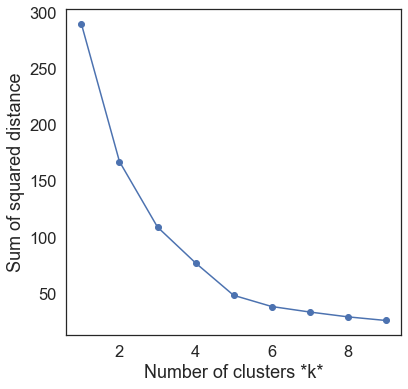

In [60]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_county)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.savefig('Select_k_eblow.png')

In [61]:
kclusters = 6

In [62]:
# Clustering
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
k_means.fit(df_county)
k_means.labels_[0:10] 

array([1, 5, 5, 0, 5, 0, 1, 0, 1, 0])

In [63]:
df_final.insert(0, 'Cluster Labels', k_means.labels_)

In [64]:
df_final.head()

,Cluster Labels,County,Population,Density,Per_capita_income,Household income,Family income,HousePrice,Latitude,Longitude,NumOfRestaurant
0,1,Alameda,1559308,2109.8,36439.0,73775.0,90822.0,880231,-22.702461,-45.545968,10.0
1,5,Alpine,1202,1.6,24375.0,61343.0,71932.0,424684,38.589393,-119.834501,0.0
2,5,Amador,37159,62.5,27373.0,52964.0,68765.0,312764,38.449089,-120.591102,0.0
3,0,Butte,221578,135.4,24430.0,43165.0,56934.0,327236,39.651927,-121.585844,0.0
4,5,Calaveras,44921,44.0,29296.0,54936.0,67100.0,330958,38.255818,-120.498149,0.0


# Analyze the clusters

## Cluster 0

In [65]:
df_cluster0 = df_final[df_final['Cluster Labels']==0]
df_cluster0 = df_cluster0[['Cluster Labels','County','Population','Per_capita_income','Family income','HousePrice','NumOfRestaurant']]
df_cluster0

,Cluster Labels,County,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
3,0,Butte,221578,24430.0,56934.0,327236,0.0
5,0,Colusa,21424,22211.0,56472.0,241486,0.0
7,0,Del Norte,28066,19424.0,52452.0,251191,0.0
9,0,Fresno,948844,20231.0,50046.0,265174,17.0
10,0,Glenn,28019,21698.0,51940.0,240063,0.0
11,0,Humboldt,134876,23516.0,53532.0,324636,0.0
12,0,Imperial,177026,16409.0,46555.0,246192,0.0
14,0,Kern,857730,20467.0,52541.0,232849,0.0
15,0,Kings,151390,18518.0,50202.0,233032,1.0
16,0,Lake,64209,21310.0,47773.0,252768,0.0


## Cluster 1

In [66]:
df_cluster1 = df_final[df_final['Cluster Labels']==1]
df_cluster1 = df_cluster1[['Cluster Labels','County','Population','Per_capita_income','Family income','HousePrice','NumOfRestaurant']]
df_cluster1

,Cluster Labels,County,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
0,1,Alameda,1559308,36439.0,90822.0,880231,10.0
6,1,Contra Costa,1081232,38770.0,95087.0,708779,0.0
8,1,El Dorado,181465,35128.0,84690.0,486195,0.0
30,1,Placer,361518,35711.0,88615.0,525269,0.0
43,1,Santa Cruz,267203,33050.0,81495.0,855995,1.0
48,1,Sonoma,491790,33361.0,76614.0,655326,0.0
55,1,Ventura,835790,33308.0,86890.0,611384,0.0


## Cluster 2

In [67]:
df_cluster2 = df_final[df_final['Cluster Labels']==2]
df_cluster2 = df_cluster2[['Cluster Labels','County','Population','Per_capita_income','Family income','HousePrice','NumOfRestaurant']]
df_cluster2

,Cluster Labels,County,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
18,2,Los Angeles,9974203,27987.0,62289.0,656790,31.0


## Cluster 3

In [68]:
df_cluster3 = df_final[df_final['Cluster Labels']==3]
df_cluster3 = df_cluster3[['Cluster Labels','County','Population','Per_capita_income','Family income','HousePrice','NumOfRestaurant']]
df_cluster3

,Cluster Labels,County,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
20,3,Marin,256802,58004.0,120030.0,1187086,0.0
37,3,San Francisco,829072,49986.0,93391.0,1436140,19.0
40,3,San Mateo,739837,47198.0,108088.0,1375001,0.0
42,3,Santa Clara,1841569,42666.0,106401.0,1227246,0.0


In [69]:
df_cluster4 = df_final[df_final['Cluster Labels']==4]
df_cluster4 = df_cluster4[['Cluster Labels','County','Population','Per_capita_income','Family income','HousePrice','NumOfRestaurant']]
df_cluster4

,Cluster Labels,County,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
27,4,Napa,139253,35092.0,81275.0,699077,29.0
29,4,Orange,3086331,34416.0,85472.0,753361,34.0
32,4,Riverside,2266899,23660.0,63523.0,400012,25.0
33,4,Sacramento,1450277,27071.0,64496.0,395943,27.0
36,4,San Diego,3183143,31043.0,74569.0,619887,28.0
41,4,Santa Barbara,431555,30526.0,73636.0,652059,23.0


In [70]:
df_cluster5 = df_final[df_final['Cluster Labels']==5]
df_cluster5 = df_cluster5[['Cluster Labels','County','Population','Per_capita_income','Family income','HousePrice','NumOfRestaurant']]
df_cluster5

,Cluster Labels,County,Population,Per_capita_income,Family income,HousePrice,NumOfRestaurant
1,5,Alpine,1202,24375.0,71932.0,424684,0.0
2,5,Amador,37159,27373.0,68765.0,312764,0.0
4,5,Calaveras,44921,29296.0,67100.0,330958,0.0
13,5,Inyo,18439,27028.0,69041.0,368090,0.0
21,5,Mariposa,17946,28327.0,63520.0,299882,0.0
25,5,Mono,14193,29578.0,73494.0,474496,0.0
26,5,Monterey,424927,25048.0,62370.0,604141,1.0
28,5,Nevada,98606,32117.0,69649.0,476825,0.0
31,5,Plumas,19286,29167.0,60709.0,283298,0.0
34,5,San Benito,56888,26317.0,71124.0,643036,0.0


## Cluster Visualization

In [72]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['County'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters